# 1. Read the data

In [1]:
import pandas as pd

# Read the csv file using read_csv method of pandas
data = pd.read_csv('treasury_prices_2002_2020.csv', index_col=0)
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')

# Calculate daily percentage changes of the prices
data = data.pct_change()

data.tail()

,SHY,IEF,TLT
Date,,,
2020-05-14,-0.000231,0.001559,0.009787
2020-05-15,0.000577,-0.000656,-0.002573
2020-05-18,-0.000808,-0.006150,-0.021954
2020-05-19,0.000577,0.002805,0.003741
2020-05-20,0.000000,0.000247,0.002994


# 2. Count days from end of month

In [2]:
import numpy as np

# Store month attribute of the day
data['month'] = data.index.month 

# Compare current day's month attribute with next day's month attribute

# The last data entry is dropped due to the NaN value after shift(-1)
data['is_last_day'] = data.month!= data.month.shift(-1)
data = data[:-1]

# Store the last date of the month
data['last_date_of_month'] = np.where(data.is_last_day, data.index.day, np.nan) 
data.last_date_of_month = data.last_date_of_month.fillna(method='bfill')

data['days_since_last_day'] = data.index.day - data.last_date_of_month
data.dropna(inplace=True)

data.head()

,SHY,IEF,TLT,month,is_last_day,last_date_of_month,days_since_last_day
Date,,,,,,,
2002-07-31,0.003086,0.009172,0.012390,7,True,31.0,0.0
2002-08-01,0.001970,0.004120,0.005695,8,False,30.0,-29.0
2002-08-02,0.001964,0.007723,0.010240,8,False,30.0,-28.0
2002-08-05,0.001594,0.005031,0.004413,8,False,30.0,-25.0
2002-08-06,-0.002447,-0.008103,-0.008549,8,False,30.0,-24.0


# 3. Analyse the returns patterns

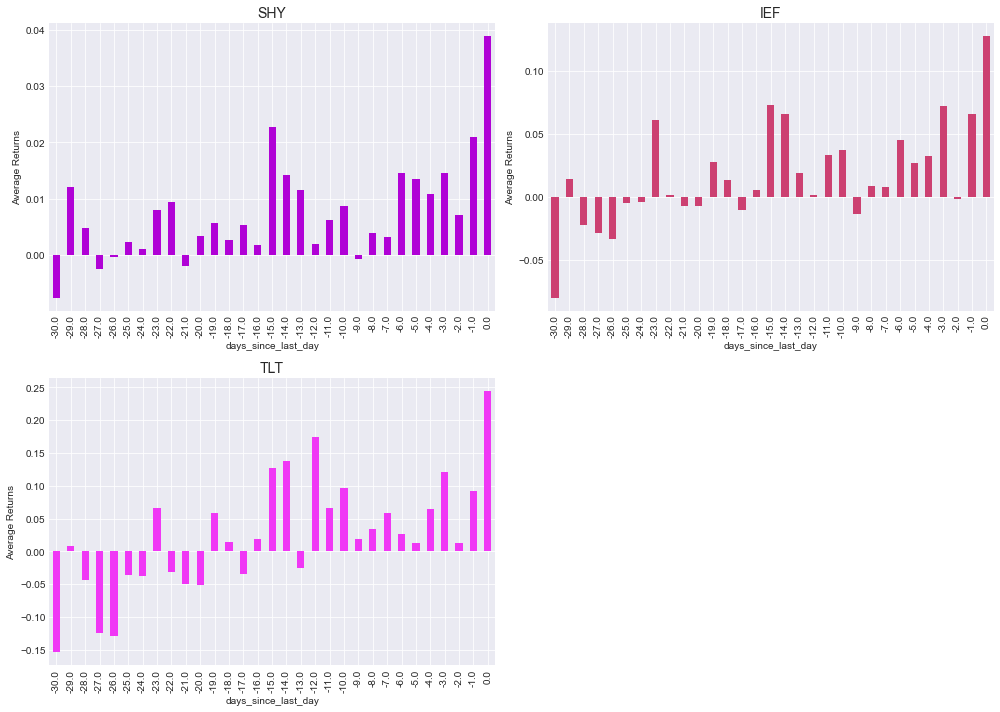

In [3]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(7*2, 5*2))

inst_list = ['SHY', 'IEF', 'TLT']
i = 1

for col in inst_list:
    # Add the subplot
    sub = fig.add_subplot(2, 2, i)
    i = i+1
    # Set title
    sub.set_title(col, fontsize=14)
    # Plot
    r = random.random()
    b = random.random()
    g = random.random()
    (data.groupby('days_since_last_day')[col].mean()*100).plot.bar(color=(r, g, b))
    sub.set_ylabel('Average Returns')

plt.tight_layout()
plt.show()

# 4. Percentage of days with positive returns

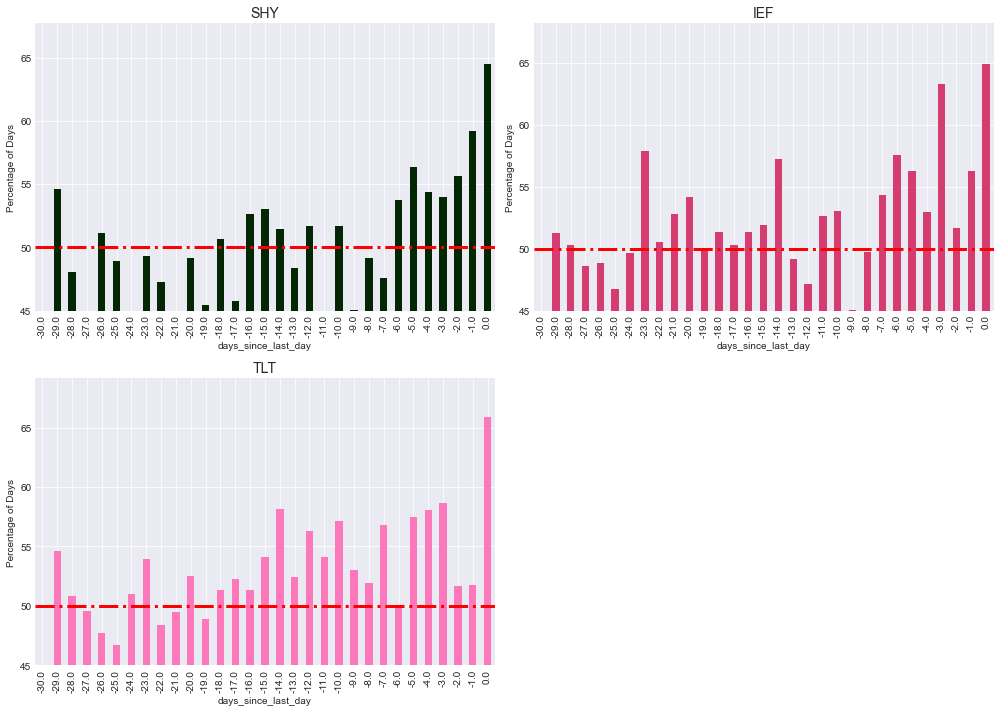

In [4]:
data_replica = data.copy()
fig = plt.figure(figsize=(7*2, 5*2))
i = 1

for col in inst_list:
    data_replica[col] = np.where(data_replica[col] > 0, 1, 0)
    days_gt_than_zero_returns = data_replica.groupby(
        'days_since_last_day')[col].sum()
    total_days = data_replica.groupby('days_since_last_day')[col].count()
    percent_days_positive_returns = 100*days_gt_than_zero_returns/total_days

    # Add the subplot
    sub = fig.add_subplot(2, 2, i)
    i = i+1
    r = random.random()
    b = random.random()
    g = random.random()
    percent_days_positive_returns.plot.bar(color=(r, g, b))
    
    # Set title, ylimit and horizontal line at 50% mark
    sub.set_title(col, fontsize=14)
    sub.set_ylim(45)
    sub.set_ylabel('Percentage of Days')
    sub.axhline(50, color='r', linestyle='dashdot', linewidth=3)

plt.tight_layout()
plt.show()

# 5. Trading logic

In [5]:
data['signal'] = np.where(data.days_since_last_day >= -6, 1, 0)

# 6. Strategy returns

In [6]:
# Calculate strategy returns
returns = data[inst_list].mul(data['signal'], axis=0)
returns.head()

,SHY,IEF,TLT
Date,,,
2002-07-31,0.003086,0.009172,0.01239
2002-08-01,0.000000,0.000000,0.00000
2002-08-02,0.000000,0.000000,0.00000
2002-08-05,0.000000,0.000000,0.00000
2002-08-06,-0.000000,-0.000000,-0.00000


In [7]:
# Calculate cumulative strategy returns
cumulative_strategy_returns = ((returns + 1).cumprod())

# Calculate strategy returns
total_strategy_returns = (cumulative_strategy_returns.iloc[-1]-1)*100

total_strategy_returns

SHY     21.361078
IEF     82.450232
TLT    165.880049
Name: 2020-04-30 00:00:00, dtype: float64

In [8]:
# Total number of trading days
days = len(cumulative_strategy_returns)

# Calculate compounded annual growth rate
cagr = (cumulative_strategy_returns.iloc[-1]**(252/days)-1)*100

print('The CAGR from strategy is')
cagr

The CAGR from strategy is


SHY    1.097661
IEF    3.448817
TLT    5.668945
Name: 2020-04-30 00:00:00, dtype: float64

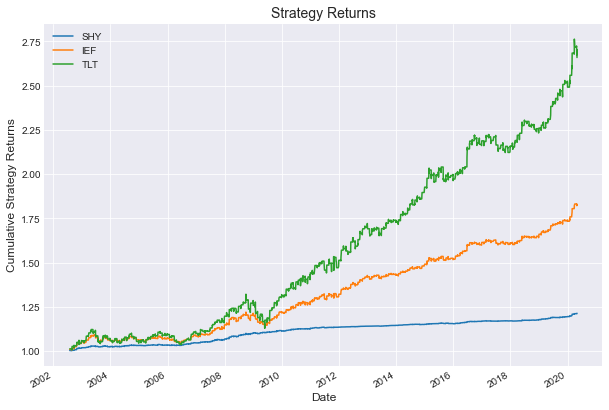

In [9]:
# Plot cumulative strategy returns
cumulative_strategy_returns.plot(figsize=(10, 7))

# Define label for the title of the figure
plt.title('Strategy Returns', fontsize=14)

# Define labels for x-axis and y-axis
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Strategy Returns', fontsize=12)

plt.show()

# 7. Drawdowns

In [10]:
def calc_drawdown(cum_rets):

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown


drawdown = calc_drawdown(cumulative_strategy_returns)
max_dd = drawdown.min()*100

max_dd

SHY    -0.641883
IEF    -7.301737
TLT   -14.575357
dtype: float64

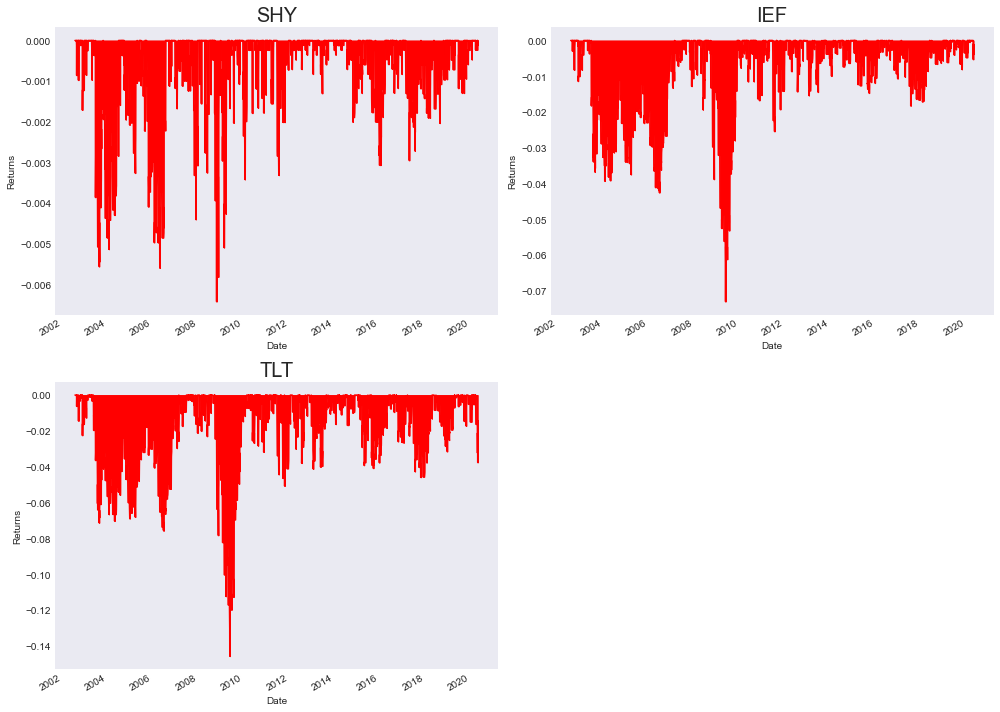

In [11]:
def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(7*2, 5*2))
    i = 1
    for col in drawdown.columns:
        # Add the subplot
        sub = fig.add_subplot(2, 2, i)
        i = i+1
        # Set title
        sub.set_title(col, fontsize=20)
        # Plot

        drawdown[col].plot(color='r')
        sub.set_ylabel('Returns')
        sub.fill_between(drawdown.index, drawdown[col], color='red')
        sub.grid(which="major", color='k', linestyle='-.', linewidth=0.2)

    plt.tight_layout()
    plt.show()


plot_drawdown(drawdown)